# **Predicting Pulsar Stars**

## **Preparation**

In [1]:
## Import modules
from google.colab import files
import matplotlib.pyplot as plt
from functools import *
import itertools
from itertools import combinations
import datetime
import pytz
import operator
import seaborn as sns
import pandas as pd
import numpy as np
np.set_printoptions(formatter = {'float': '{: 0.1f}'.format})

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


In [2]:
## Uploading files [pulsar_stars.csv]
## Source: https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star
file_name = 'pulsar_stars.csv'
uploaded = files.upload()

Saving pulsar_stars.csv to pulsar_stars.csv


## **Exploratory Data Analysis (EDA)**

In [0]:
## Loading the dataset
dataset = pd.read_csv(file_name, delimiter=',')

In [4]:
## Exploring the dataset
print("Number of Example (rows): %s" % dataset.shape[0])
print("Number of Features (columns): %s" % dataset.shape[1])

Number of Example (rows): 17898
Number of Features (columns): 9


In [5]:
## Inspecting the dataset
dataset.columns = ['mean_profile', 'standard_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr', 'standard_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr', 'target']
dataset.head()

,mean_profile,standard_profile,kurtosis_profile,skewness_profile,mean_dmsnr,standard_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [6]:
## View data types
dataset.info()

## Check if dataset free from null values
print('')
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_profile      17898 non-null  float64
 1   standard_profile  17898 non-null  float64
 2   kurtosis_profile  17898 non-null  float64
 3   skewness_profile  17898 non-null  float64
 4   mean_dmsnr        17898 non-null  float64
 5   standard_dmsnr    17898 non-null  float64
 6   kurtosis_dmsnr    17898 non-null  float64
 7   skewness_dmsnr    17898 non-null  float64
 8   target            17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB



mean_profile        0
standard_profile    0
kurtosis_profile    0
skewness_profile    0
mean_dmsnr          0
standard_dmsnr      0
kurtosis_dmsnr      0
skewness_dmsnr      0
target              0
dtype: int64

### **Visualize the distribution of each input features**

Range of the values (min, max, mean, median, etc.)

In [7]:
## Basic statistical details like percentile, mean, std etc. of a data frame
dataset.describe()

,mean_profile,standard_profile,kurtosis_profile,skewness_profile,mean_dmsnr,standard_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


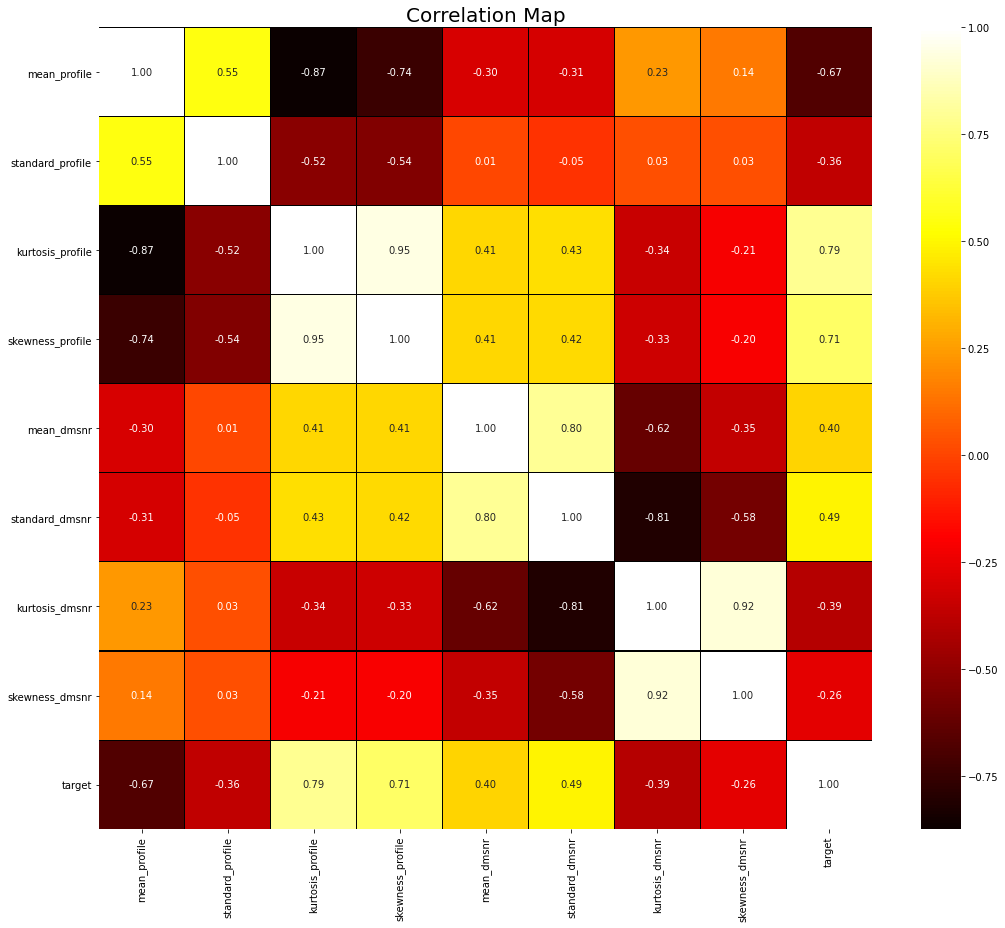

In [8]:
## Correlation between fields
plt.figure(figsize=(15, 13))
sns.heatmap(data=dataset.corr(), annot=True, cmap="hot", linewidths=0.1, fmt=".2f", linecolor="black")
plt.title("Correlation Map", fontsize=20)
plt.tight_layout()
plt.show()

Histograms distribution of each input features

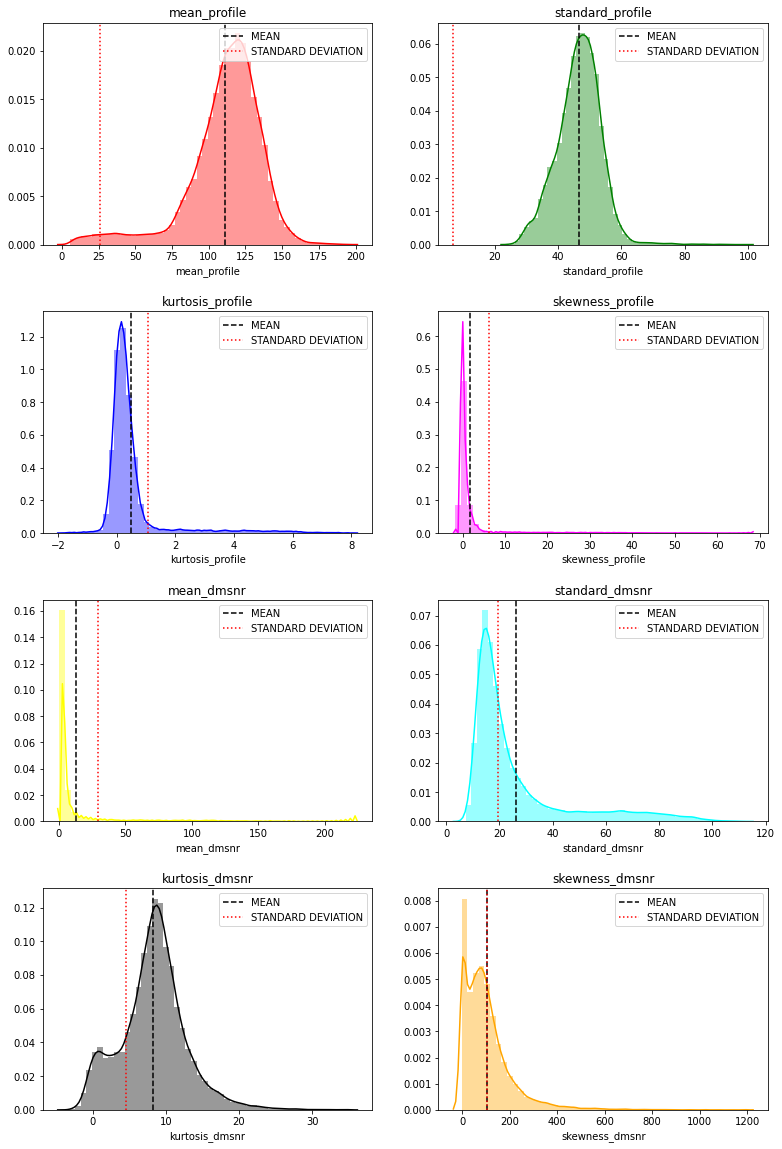

In [9]:
columns = ['mean_profile', 'standard_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr', 'standard_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr']
columns_length  = len(columns)
columns_colors  = ["red", "green", "blue", "magenta", "yellow", "cyan", "black", "orange"] 

## Make an iterator that aggregates elements from each of the iterables
plt.figure(figsize=(13, 20))
for i, j, k in itertools.zip_longest(columns, range(columns_length), columns_colors):
    plt.subplot(columns_length/2, columns_length/4, j + 1)
    sns.distplot(dataset[i], color = k)
    plt.title(i)
    plt.subplots_adjust(hspace = 0.3)
    plt.axvline(dataset[i].mean(), color = "black", linestyle="dashed", label="MEAN")
    plt.axvline(dataset[i].std(), color = "red", linestyle="dotted", label="STANDARD DEVIATION")
    plt.legend(loc="upper right")

### **Distribution of the output labels**
The data is imbalanced and will need to be resampled, such as oversampling, undersampling, or generate synthetic samples.

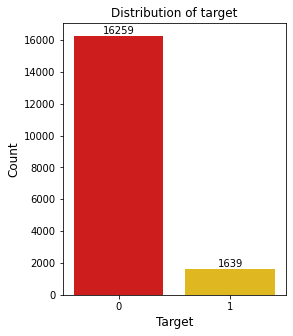

In [10]:
## Distribution of target class
plt.figure(figsize=(4, 5))
axs = sns.countplot(dataset['target'], palette='hot')
plt.title('Distribution of target', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Count', fontsize=12)

## Count Annotation
for rec in axs.patches:
    axs.annotate(format(rec.get_height(), '.0f'), (rec.get_x() + rec.get_width() / 2.0, rec.get_height()), ha='center', va='center', xytext=(0, 5), textcoords = 'offset points', fontsize=10)

## **Training and Validation Sets**

In [0]:
## Shuffle the dataset
## NOTE: shuffle dataframe in-place and reset the index
## NOTE: don't need to shuffle here because train_test_split will take care of it
# dataset = dataset.sample(frac=1).reset_index(drop=True)

## Convert Pandas Dataframe to Numpy dArray
dataset_np = dataset.values
X = dataset.drop('target', axis='columns').values
Y = dataset['target'].values

In [0]:
## Index for 20%
# index_20percent = int(0.2 * len(dataset_np[:, 0]))  
# print(index_20percent)

## Split into validation (20%) and training (80%)
# XVALID = X[:index_20percent, :]
# YVALID = Y[:index_20percent]

# XTRAIN = X[index_20percent:, :]
# YTRAIN = Y[index_20percent:]

## NOTE: using sklearn instead
XTRAIN, XVALID, YTRAIN, YVALID = train_test_split(X, Y, test_size = 0.2, random_state = 2020)

## **Data Normalization**

**IMPORTANT**: Do standardization/normalization after spliting into train and test/validation. The reason is to avoid any data leakage. </br>
**Standardization/Normalization Techniques** </br>
* Standardization: typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance). 
* Normalization: typically means rescales the values into a range of [0, 1]
* Normalization is a good technique to use when you do not know the distribution of your data or when you know the distribution is not Gaussian (a bell curve).
* Standardization assumes that your data has a Gaussian (bell curve) distribution. This does not strictly have to be true, but the technique is more effective if your attribute distribution is Gaussian.
* **Source Code**: https://github.com/badriadhikari/AI-2020spring/blob/master/notebooks/normalization_techniques.ipynb

In [0]:
## Mean normalization
min = XTRAIN.min(axis = 0) 
max = XTRAIN.max(axis = 0) 
mean = XTRAIN.mean(axis = 0)
XTRAIN = (XTRAIN - mean) / (max - min)
XVALID = (XVALID - mean) / (max - min)

## Rescaling
## NOTE: no need to rescale for a binary classification problem
# Ymax = YTRAIN.max()
# YTRAIN = YTRAIN / Ymax
# YVALID = YVALID / Ymax

### **Verifying**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74988abeb8>,
      dtype=object)

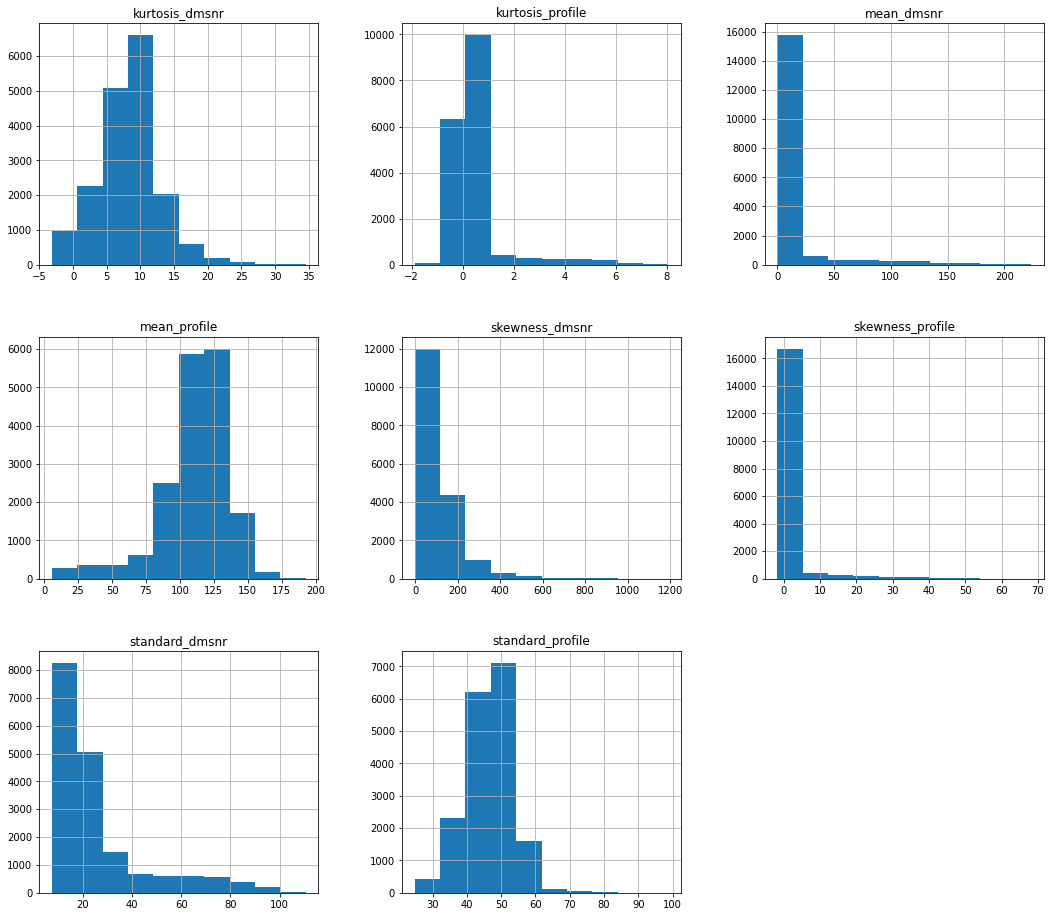

In [14]:
## Before Normalize
dataset.drop('target', axis='columns').hist(figsize=(18,16))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f749602e240>,
      dtype=object)

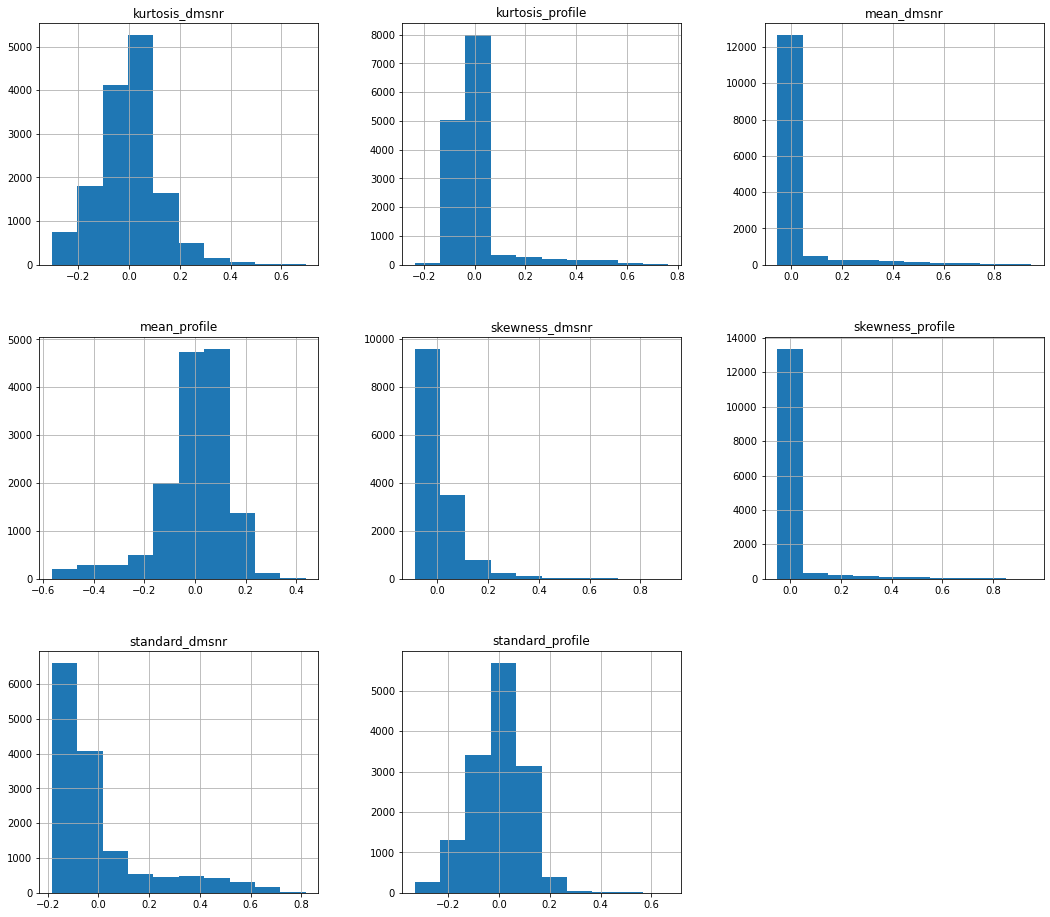

In [15]:
## After Normalize
dfx = pd.DataFrame(data=XTRAIN)
dfx.columns = ['mean_profile', 'standard_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr', 'standard_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr']
dfx.hist(figsize=(18,16))

## **Construct Neural Network (NN)**

In [16]:
## Baseline Model #1
model1 = Sequential()
model1.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
## Baseline Model #2
model2 = Sequential()
model2.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))
model2.add(Dense(6, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [0]:
## Baseline Model #3
model3 = Sequential()
model3.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))
model3.add(Dense(6, activation='relu'))
model3.add(Dense(4, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

In [0]:
## Model using linear activation (only last neuron)
modelA = Sequential()
modelA.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))
modelA.add(Dense(4, activation='relu'))
modelA.add(Dense(1, activation='linear'))

In [0]:
## Model using linear activation (all neurons)
modelB = Sequential()
modelB.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='linear'))
modelB.add(Dense(4, activation='linear'))
modelB.add(Dense(1, activation='linear'))

In [0]:
## Model using sigmoid activation (only last neuron)
modelC = Sequential()
modelC.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))
modelC.add(Dense(4, activation='relu'))
modelC.add(Dense(1, activation='sigmoid'))

In [0]:
## Model using sigmoid activation (all neurons)
modelD = Sequential()
modelD.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='sigmoid'))
modelD.add(Dense(4, activation='sigmoid'))
modelD.add(Dense(1, activation='sigmoid'))

In [0]:
## Model using sigmoid with leaky relu activation
## The dying ReLU problem happens if the input becomes too large causing the gradient to update the weights such that the summation, and thus the input, will always be less than zero for the rest of the training session.
## Source: https://www.quora.com/What-is-the-dying-ReLU-problem-in-neural-networks
modelE = Sequential()
modelE.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation=partial(tf.nn.leaky_relu, alpha=0.1)))
modelE.add(Dense(4, activation=partial(tf.nn.leaky_relu, alpha=0.1)))
modelE.add(Dense(1, activation='sigmoid'))

In [0]:
## Overfitting Model
modelF = Sequential()
modelF.add(Dense(80, input_dim = len(XTRAIN[0, :]), activation=partial(tf.nn.leaky_relu, alpha=0.1)))
modelF.add(Dense(40, activation=partial(tf.nn.leaky_relu, alpha=0.1)))
modelF.add(Dense(1, activation='sigmoid'))

In [0]:
## Model using more hidden layers
modelG = Sequential()
modelG.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))
modelG.add(Dense(16, activation='relu'))
modelG.add(Dense(16, activation='relu'))
modelG.add(Dense(8, activation='relu'))
modelG.add(Dense(4, activation='relu'))
modelG.add(Dense(1, activation='sigmoid'))

## **Compile NN Model**

Binary Classification Loss Functions
* Binary Cross Entropy Loss
* Hinge Loss

**More Info**: 
* https://www.analyticsvidhya.com/blog/2019/08/detailed-guide-7-loss-functions-machine-learning-python-code/
* https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0

Using Adaptive Moment Estimation (Adam) because it automatically tunes itself and gives good results in a wide range of problems. 

In [26]:
## Compile our model
model1.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model2.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model3.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
modelA.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
modelB.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
modelC.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
modelD.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
modelE.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
modelF.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
modelG.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

all_model = []
all_model.append(model1)
all_model.append(model2)
all_model.append(model3)
all_model.append(modelA)
all_model.append(modelB)
all_model.append(modelC)
all_model.append(modelD)
all_model.append(modelE)
all_model.append(modelF)
all_model.append(modelG)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Fitting our model**

**Batch Size**: defines the number of samples that will be propagated through the network. I.e. let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network.

**In general**: Larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. It's definitely problem dependent.

In [0]:
callback_files = ["model1.hdf5", "model2.hdf5", "model3.hdf5", "modelA.hdf5", "modelB.hdf5", "modelC.hdf5", "modelD.hdf5", "modelE.hdf5", "modelF.hdf5", "modelG.hdf5"]
model_names = ["Baseline Model A", "Baseline Model B", "Baseline Model C", "Model A", "Model B", "Model C", "Model D", "Model E", "Model F", "Model G"]

In [0]:
all_history = []
for index, (model, file) in enumerate(zip(all_model, callback_files)):
    callback_a = ModelCheckpoint(filepath = file, monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=100, verbose=0)
    history = model.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 1024, batch_size=128, callbacks = [callback_a, callback_b], verbose = 0)
    all_history.append(history)

## **NN Model Evaluation**


For Binary Classification only:
* **Confusion Matrix**: is a simple to layout how many predicted categories or classes were correctly predicted and how many were not.
* **Goals**: we want as many predictions as possible where more trues than falses.
* Evaluate the loss value and metrics values for the model in test mode using evaluate function.
* Predict the output for our valid dataset. If the prediction is greater than 0.5 then the output is 1 else the output is 0.
* Check the accuracy on the valid dataset with confusion matrix.

**Source:** https://machinelearningmastery.com/confusion-matrix-machine-learning/

In [0]:
def model_evaluation_classification(xvalid, yvalid, model, callback_file):
    scores = model.evaluate(xvalid, yvalid)
    print("%s: %.2f" % (model.metrics_names[0], scores[0]))
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

    model.load_weights(callback_file)
    prediction = model.predict(xvalid)
    prediction = (prediction > 0.5)
    cm = confusion_matrix(yvalid, prediction)
    acc = (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()) * 100
    print("\n%s" % cm)
    print("%.2f%%\n" % acc)

    accuracy = accuracy_score(yvalid, prediction.round()) * 100.0
    precision = precision_score(yvalid, prediction.round()) * 100.0
    recall = recall_score(yvalid, prediction.round()) * 100.0
    f1score = f1_score(yvalid, prediction.round())

    print("Accuracy: %.2f%%" % (accuracy))
    print("Precision: %.2f%%" % (precision))
    print("Recall: %.2f%%" % (recall))
    print("F1-score: %.2f\n" % (f1score))

    for i in range(10):
	    print("X=%s, Predicted=%s" % (xvalid[i], prediction[i]))
    return prediction

def model_evaluation_regression(xvalid, yvalid, model, callback_file):
    scores = model.evaluate(xvalid, yvalid)
    print("%s: %.2f" % (model.metrics_names[0], scores[0]))
    print("%s: %.2f" % (model.metrics_names[1], scores[1]))

    model.load_weights(callback_file)
    prediction = model.predict(xvalid)
    mae = mean_absolute_error(yvalid, prediction)
    prediction = (prediction > 0.5)
    print("MAE: %.2f\n" % (mae))

    for i in range(10):
	    print("X=%s, Predicted=%s" % (xvalid[i], prediction[i]))
    return prediction

In [30]:
all_prediction = []
for index, (name, model, callback_file) in enumerate(zip(model_names, all_model, callback_files)):
    print("================================================== %s ==================================================" % name)
    if index == 3 or index == 4:
        pred = model_evaluation_regression(XVALID, YVALID, model, callback_file)
        all_prediction.append(pred)
    else:
        pred = model_evaluation_classification(XVALID, YVALID, model, callback_file)
        all_prediction.append(pred)
    print()

================================================== Baseline Model A ==================================================
3580/3580 [==============================] - 0s 42us/sample - loss: 0.0675 - acc: 0.9799
loss: 0.07
acc: 97.99%

[[3219   25]
 [  48  288]]
97.96%

Accuracy: 97.96%
Precision: 92.01%
Recall: 85.71%
F1-score: 0.89

X=[-0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[-0.1  0.1  0.0 -0.0  0.0  0.2 -0.2 -0.1], Predicted=[ True]
X=[ 0.0  0.0 -0.0 -0.0 -0.1 -0.1  0.2  0.1], Predicted=[False]
X=[-0.0  0.1 -0.0 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[-0.1 -0.1  0.0 -0.0 -0.1 -0.1  0.1  0.1], Predicted=[False]
X=[-0.0 -0.0  0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]
X=[-0.1 -0.2  0.0  0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[-0.0  0.0 -0.0 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2 -0.1 -0.1 -0.0  0.8  0.1 -0.2 -0.1], Predicted=[False]

====================================

## **Learning curves**

In [0]:
def learning_curves_logistic(name, model_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(name)
    ax1.plot(model_history.history['loss'])
    ax1.plot(model_history.history['val_loss'])
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['training loss data', 'validation loss data'], loc="best")

    ax2.plot(model_history.history['acc'])
    ax2.plot(model_history.history['val_acc'])
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(['training accuracy data', 'validation accuracy data'], loc='best')
    fig.show()

def learning_curves_linear(name, model_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(name)
    ax1.plot(model_history.history['loss'])
    ax1.plot(model_history.history['val_loss'])
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['training loss data', 'validation loss data'], loc='best')

    ax2.plot(model_history.history['mean_absolute_error'])
    ax2.plot(model_history.history['val_mean_absolute_error'])
    ax2.set_ylabel('error')
    ax2.set_xlabel('epoch')
    ax2.legend(['training error data', 'validation error data'], loc='best')
    fig.show()

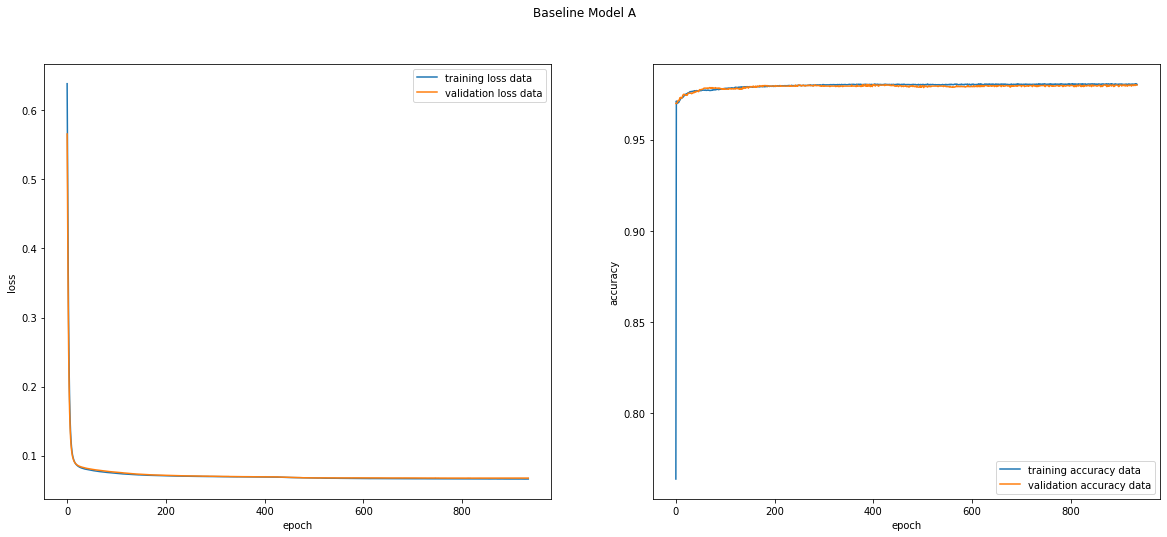

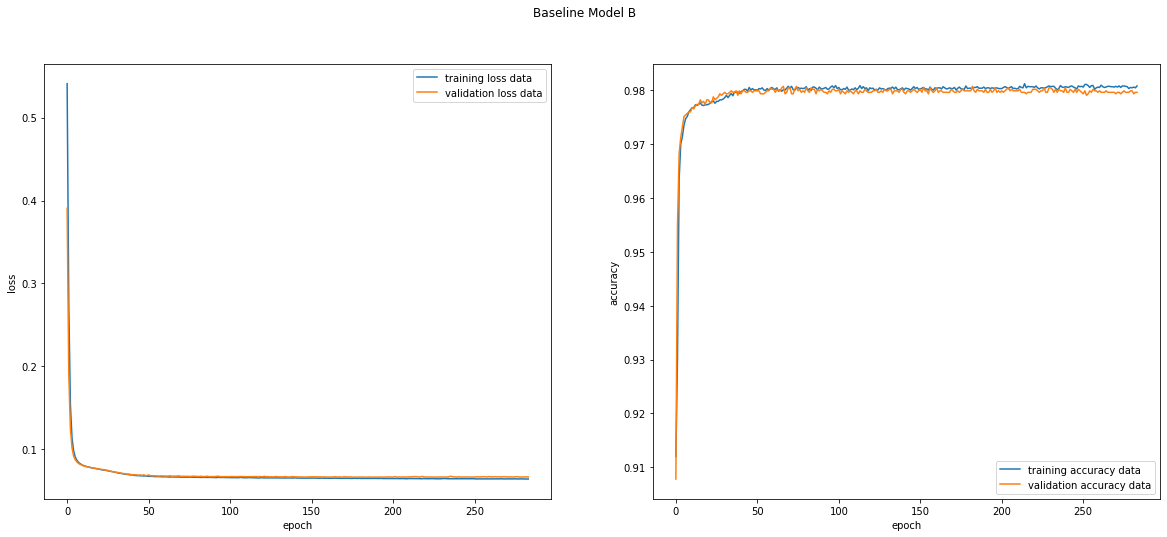

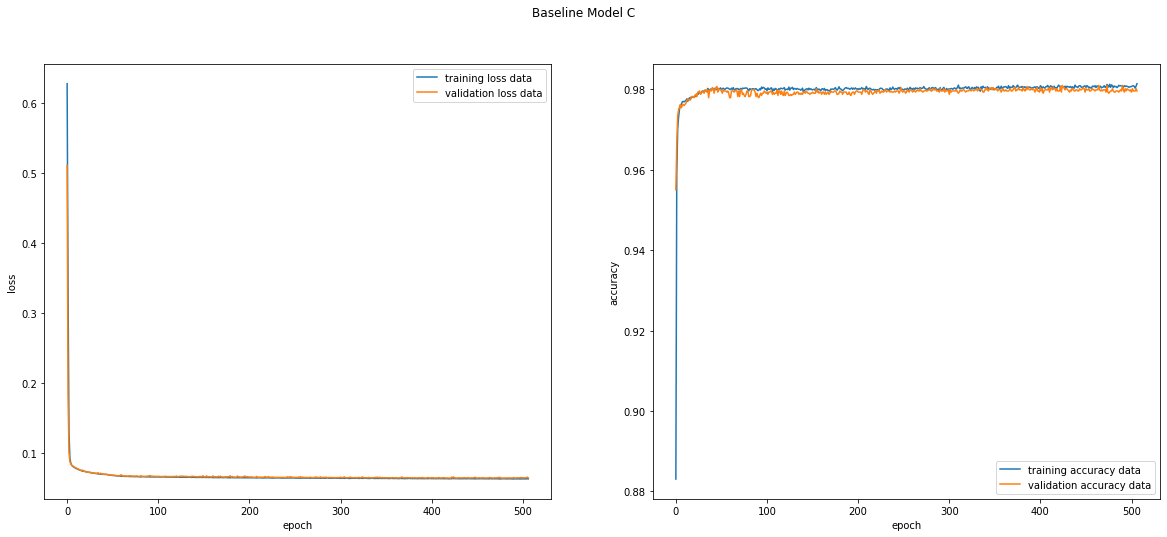

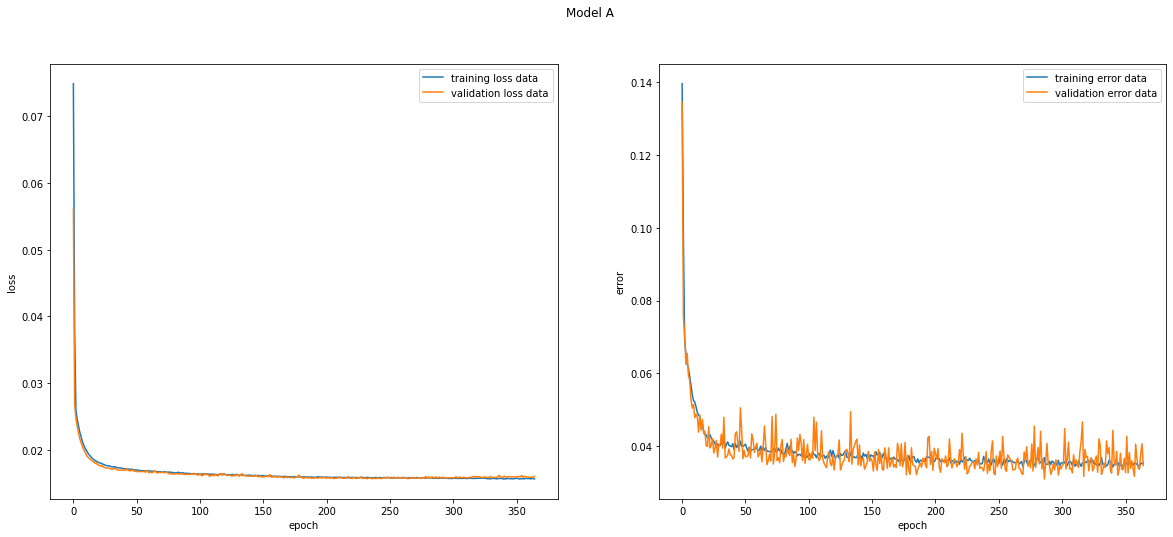

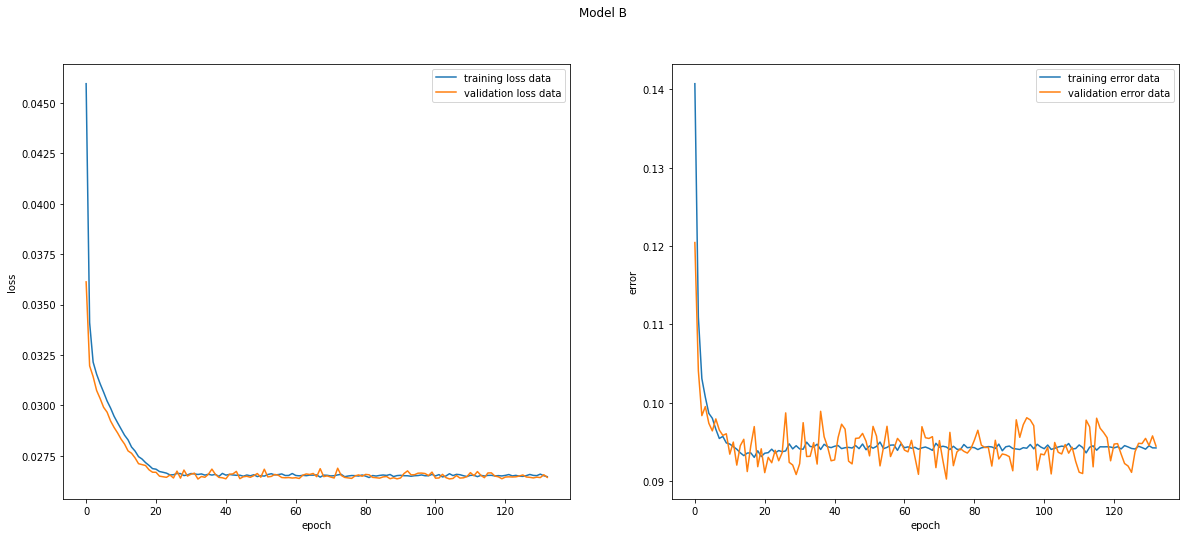

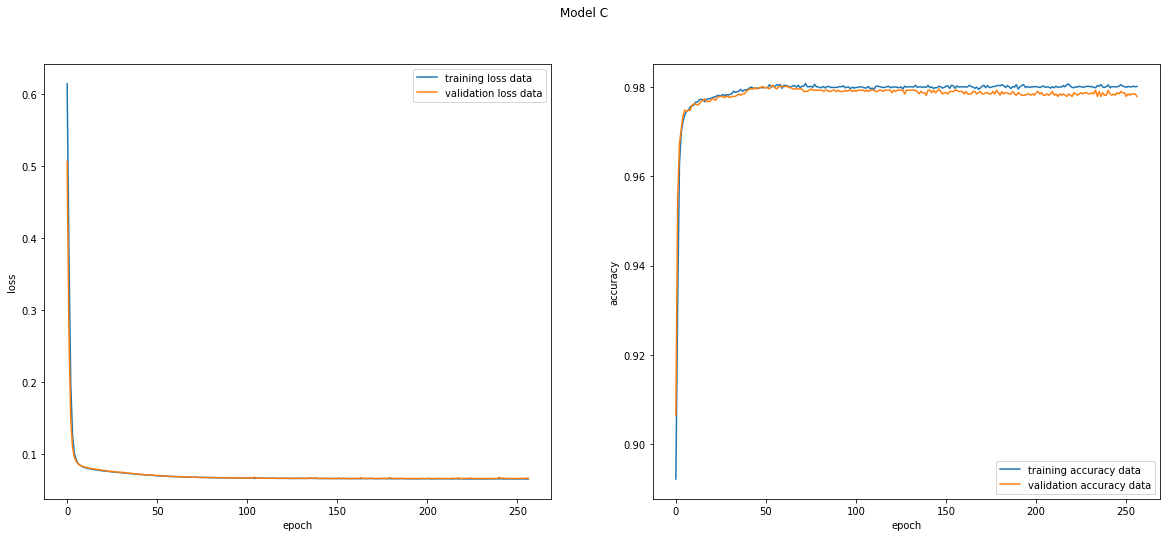

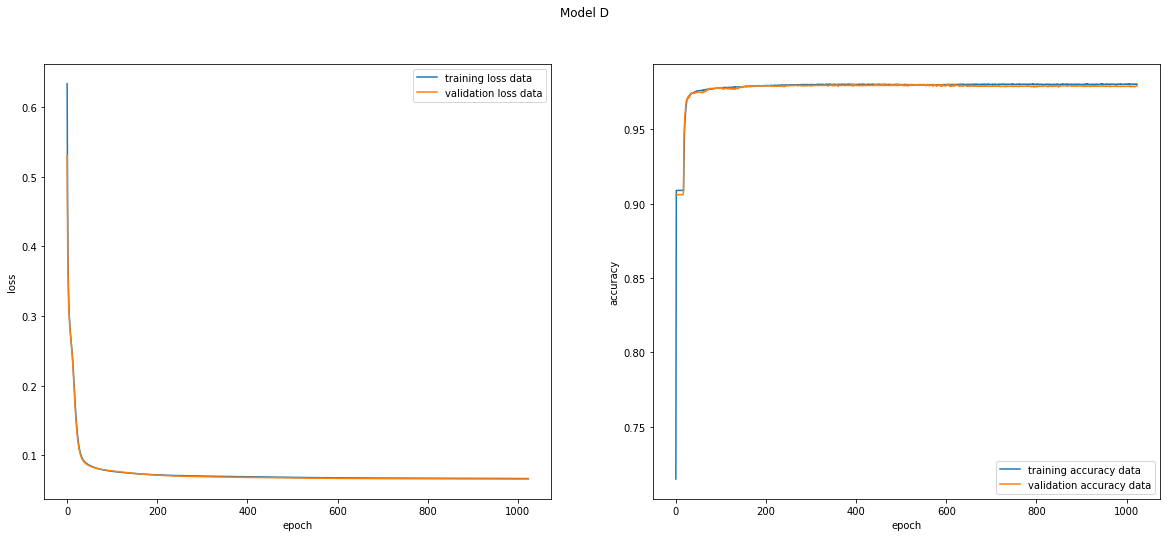

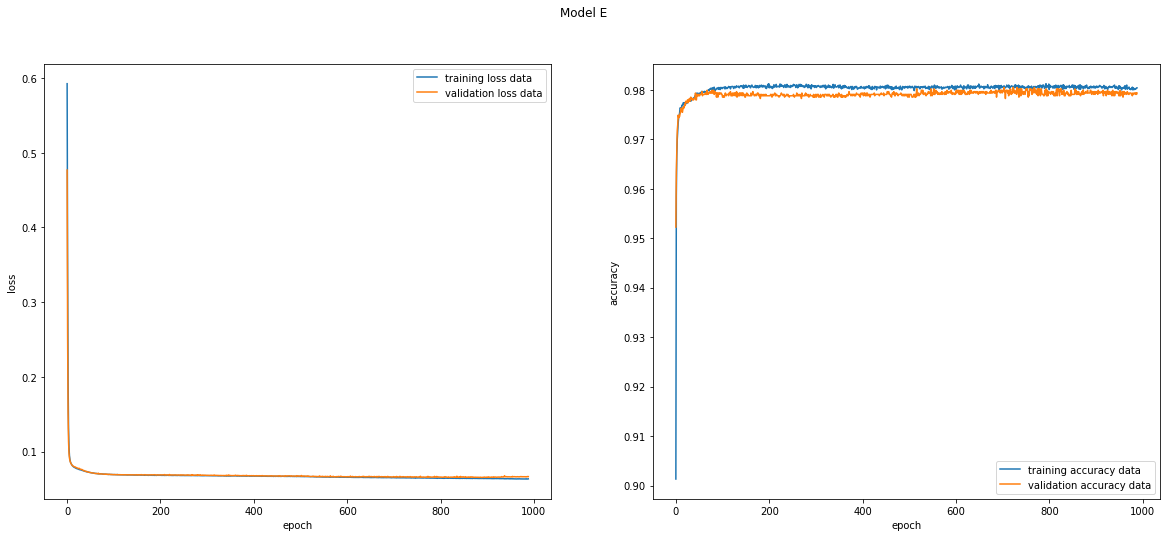

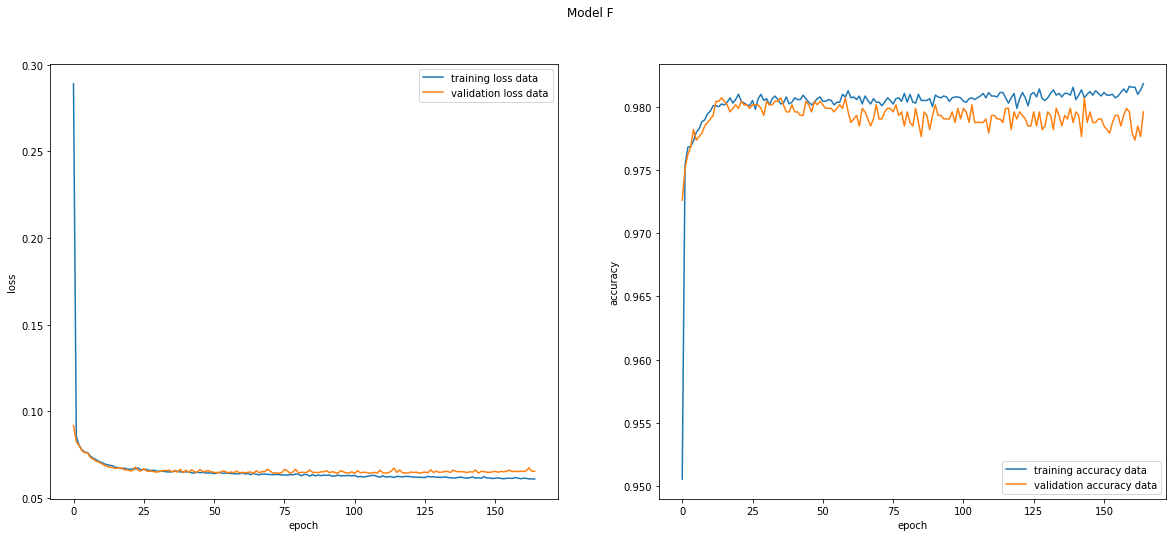

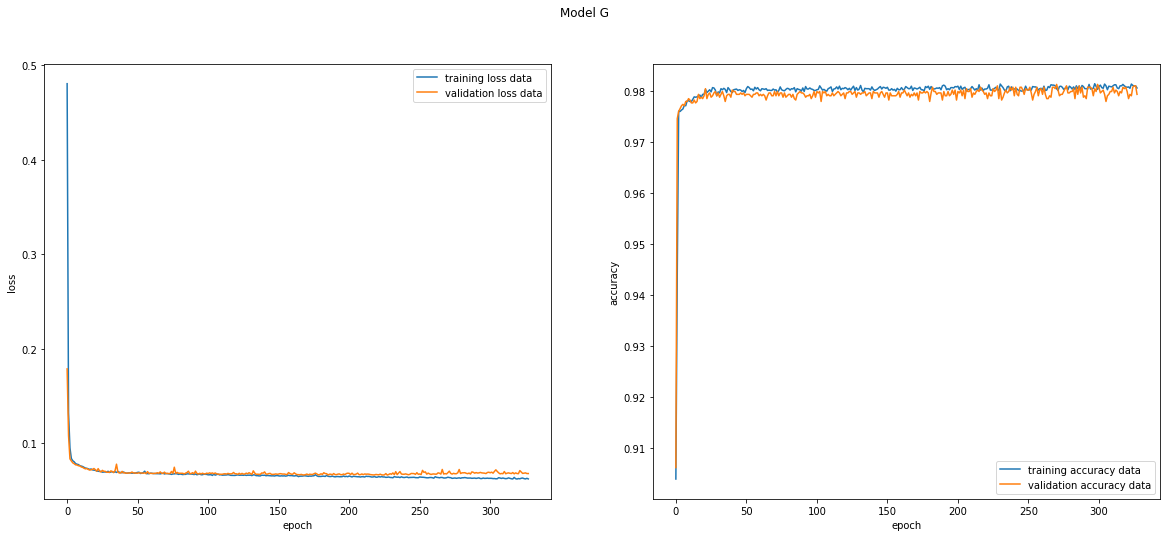

In [32]:
for index, (name, history) in enumerate(zip(model_names, all_history)):
    if index == 3 or index == 4:
        learning_curves_linear(name, history)
    else:
        learning_curves_logistic(name, history)

## **Model Performances**


**What Are ROC Curves?** A useful tool when predicting the probability of a binary outcome is the Receiver Operating Characteristic curve, or ROC curve. The area covered by the curve is the area between the red line and the axis. This area covered is AUC. The bigger the area covered, the better the machine learning models is at distinguishing the given classes. In other words, the AUC can be used as a summary of the model skill. Ideal value for AUC is 1.

**Test accuracy** The closer the graph is to the top and left-hand borders, the more accurate the test. Likewise, the closer the graph to the diagonal, the less accurate the test. A perfect test would go straight from zero up the the top-left corner and then straight across the horizontal.

**Source:** https://stackabuse.com/understanding-roc-curves-with-python/

In [0]:
def model_performances(yvalid, ypred, name="ROC Curve"):
    fpr, tpr, thresholds = roc_curve(YVALID, ypred)
    fig, ax = plt.subplots()
    fig.suptitle(name)
    ax.plot([0, 1], [0, 1], linestyle = "dashed" ,color="b")
    ax.plot(fpr, tpr ,color="red", label=('Area under the curve: ', round(auc(fpr, tpr), 4)))
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate', fontsize=10)
    ax.legend(loc='best', fontsize=10)
    fig.show()

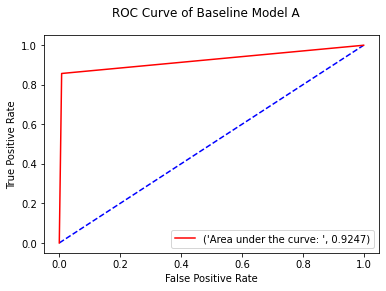

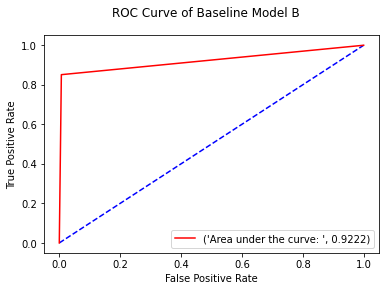

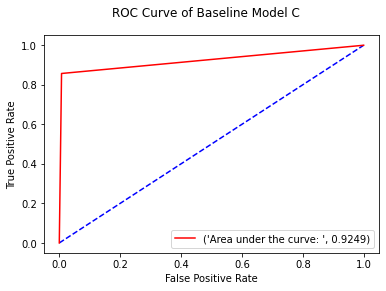

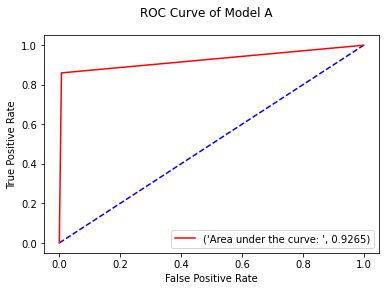

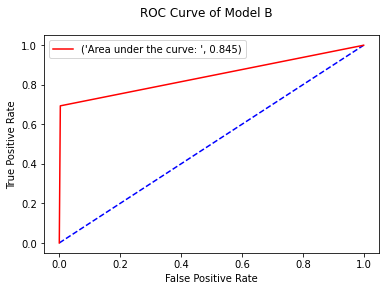

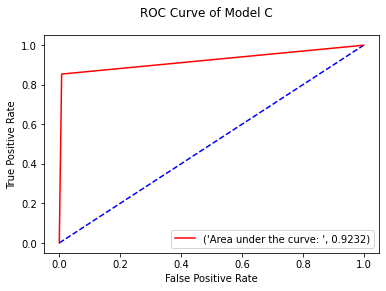

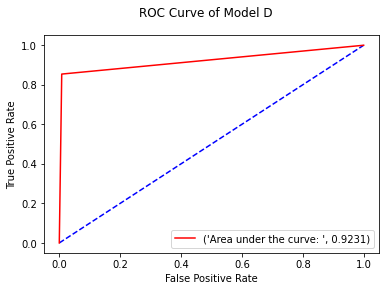

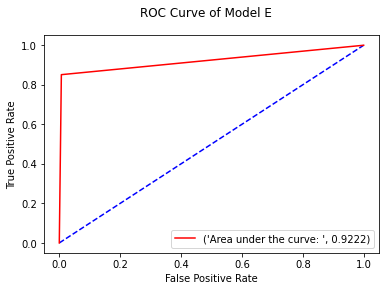

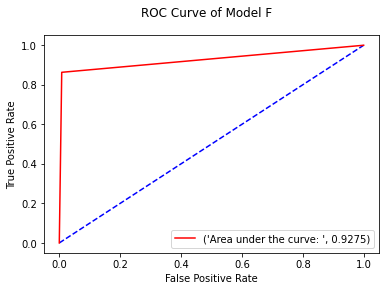

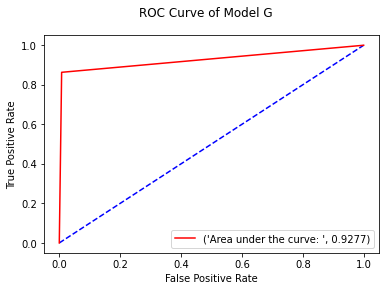

In [34]:
for (name, pred) in zip(model_names, all_prediction):
    model_performances(YVALID, pred, 'ROC Curve of %s' % name)

## **Verifying Model Prediction**
For Model C
* all_model[5]
* 3 layers
* Input Layers : Relu
* Hidden Layers : Relu
* Output Layers : Sigmoid

In [0]:
## Rectified Linear function
def rectified(x):
	return np.maximum(0, x)

## Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(np.negative(x)))

def custom_predict(validXData, validYData, model, display_weight=None):
    prediction = validXData
    layTotal = len(model.layers)

    for layNum, lay in enumerate(model.layers):
        weights = lay.get_weights()[0].T
        biases = lay.get_weights()[1].T
        if display_weight is not None:
            print("Layer #%s" %layNum)
            print("Weights:\n %s" % weights)
            print("Bias:\n %s\n" % biases)

        holder = []
        for row in prediction:
            value = []
            for i, w in enumerate(weights):                
                val = np.dot(w, row) + biases[i]
                value.append(val)

            if layNum < layTotal - 1:
                holder.append(rectified(value))
            else:
                holder.append(sigmoid(value))
            
        ## Update new input value
        prediction = np.array(holder)
    prediction = (prediction > 0.5)

    accuracy = accuracy_score(validYData, prediction.round()) * 100.0
    precision = precision_score(validYData, prediction.round()) * 100.0
    recall = recall_score(validYData, prediction.round()) * 100.0
    f1score = f1_score(validYData, prediction.round())

    print("Accuracy: %.2f%%" % (accuracy))
    print("Precision: %.2f%%" % (precision))
    print("Recall: %.2f%%" % (recall))
    print("F1-score: %.2f\n" % (f1score))

    for i in range(10):
	    print("X=%s, Predicted=%s" % (validXData[i], prediction[i]))
    return prediction

In [36]:
cpred = custom_predict(XVALID, YVALID, all_model[5], display_weight=True)

Layer #0
Weights:
 [[ 0.9  1.1 -1.9 -0.7 -0.4  0.2  0.7  0.2]
 [-0.6  0.2 -1.7 -0.5  0.1  0.0 -0.0 -0.3]
 [ 0.9  0.1  1.9  0.1 -0.2  0.3  0.6 -0.1]
 [ 1.1 -0.4  0.5 -0.2 -1.5 -0.0  0.4 -0.5]
 [ 2.0  2.0 -1.3 -0.6  1.4  0.4 -1.4 -0.1]
 [-0.0 -1.2 -3.6 -0.9  0.5 -0.5 -0.6  0.7]
 [ 0.0 -0.5 -1.5  0.3 -0.5 -2.0 -0.8  0.8]
 [-0.3  0.3  1.6 -0.2  0.3 -0.3 -0.5 -0.3]]
Bias:
 [ 0.1  0.4  0.1  0.4  0.2  0.3  0.3  0.2]

Layer #1
Weights:
 [[ 1.4  1.1 -1.8  0.3  1.2  1.1  1.2 -0.4]
 [ 1.2  1.0 -0.7 -0.4  0.6  1.1  1.3  0.1]
 [-1.8 -0.3  0.9  1.7  0.3 -2.3 -1.3  0.6]
 [-1.7 -0.4  1.0  0.7  0.7 -2.0 -0.6  1.1]]
Bias:
 [ 0.3  0.6  0.3  0.1]

Layer #2
Weights:
 [[-1.4 -0.9  2.0  2.1]]
Bias:
 [-0.3]

Accuracy: 97.93%
Precision: 91.99%
Recall: 85.42%
F1-score: 0.89

X=[-0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[-0.1  0.1  0.0 -0.0  0.0  0.2 -0.2 -0.1], Predicted=[ True]
X=[ 0.0  0.0 -0.0 -0.0 -0.1 -0.1  0.2  0.1], Predicted=[False]
X=[-0.0  0.1 -0.0 -0.0 -0.0 -0.1 -0.0 -0.0], Predic

In [37]:
## Model using sigmoid activation (only last neuron)
vpred = model_evaluation_classification(XVALID, YVALID, all_model[5], callback_files[5])

3580/3580 [==============================] - 0s 47us/sample - loss: 0.0654 - acc: 0.9793
loss: 0.07
acc: 97.93%

[[3219   25]
 [  49  287]]
97.93%

Accuracy: 97.93%
Precision: 91.99%
Recall: 85.42%
F1-score: 0.89

X=[-0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[-0.1  0.1  0.0 -0.0  0.0  0.2 -0.2 -0.1], Predicted=[ True]
X=[ 0.0  0.0 -0.0 -0.0 -0.1 -0.1  0.2  0.1], Predicted=[False]
X=[-0.0  0.1 -0.0 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[-0.1 -0.1  0.0 -0.0 -0.1 -0.1  0.1  0.1], Predicted=[False]
X=[-0.0 -0.0  0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]
X=[-0.1 -0.2  0.0  0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[-0.0  0.0 -0.0 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2 -0.1 -0.1 -0.0  0.8  0.1 -0.2 -0.1], Predicted=[False]


## **Feature Importance and Reduction**

##### Significance (importance) of each feature

In [38]:
importance_feature_columns = []
importance_feature = []

for index in range(dataset.shape[1] - 1):
    ## Get the column
    x = dataset[dataset.columns[index]].values
    y = dataset['target'].values

    ## Index for 30%
    i_30 = int(0.3 * len(dataset_np[:, 0]))

    ## Split into training and validation
    xvalid = x[:i_30]
    yvalid = y[:i_30]
    
    xtrain = x[i_30:]
    ytrain = y[i_30:]

    ## Mean normalization
    min = xtrain.min(axis = 0) 
    max = xtrain.max(axis = 0) 
    mean = xtrain.mean(axis = 0)
    xtrain = (xtrain - mean) / (max - min)
    xvalid = (xvalid - mean) / (max - min)

    ## Rescaling
    ymax = ytrain.max()
    ytrain = ytrain / ymax
    yvalid = yvalid / ymax

    ## Callback
    callback_a = ModelCheckpoint(filepath = "significance_removal.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=100, verbose=0)

    ## Model
    model = Sequential()
    model.add(Dense(8, input_dim=1, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    ## Compile Model
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    history = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=1024, batch_size=100, callbacks=[callback_a, callback_b], verbose=0)
    
    ## Prediction
    prediction = model.predict(xvalid, verbose=0)
    prediction = (prediction > 0.5)
    acc_score = accuracy_score(yvalid, prediction)

    ## Store Accuracy
    importance_feature_columns.append(dataset.columns[index])
    importance_feature.append(acc_score)
    print("%s | %s | %s" % (datetime.datetime.now(pytz.timezone('US/Central')).strftime("%Y/%m/%d %I:%M:%S %p"), dataset.columns[index], acc_score))
## ~~~
print()
print(importance_feature_columns)
print(importance_feature)

2020/05/06 06:05:03 PM | mean_profile | 0.9457999627491153
2020/05/06 06:06:20 PM | standard_profile | 0.8906686533805178
2020/05/06 06:07:09 PM | kurtosis_profile | 0.9649841683739989
2020/05/06 06:08:57 PM | skewness_profile | 0.949711305643509
2020/05/06 06:11:14 PM | mean_dmsnr | 0.8569566027193146
2020/05/06 06:12:50 PM | standard_dmsnr | 0.8716707021791767
2020/05/06 06:13:36 PM | kurtosis_dmsnr | 0.8569566027193146
2020/05/06 06:14:34 PM | skewness_dmsnr | 0.8569566027193146

['mean_profile', 'standard_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr', 'standard_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr']
[0.9457999627491153, 0.8906686533805178, 0.9649841683739989, 0.949711305643509, 0.8569566027193146, 0.8716707021791767, 0.8569566027193146, 0.8569566027193146]


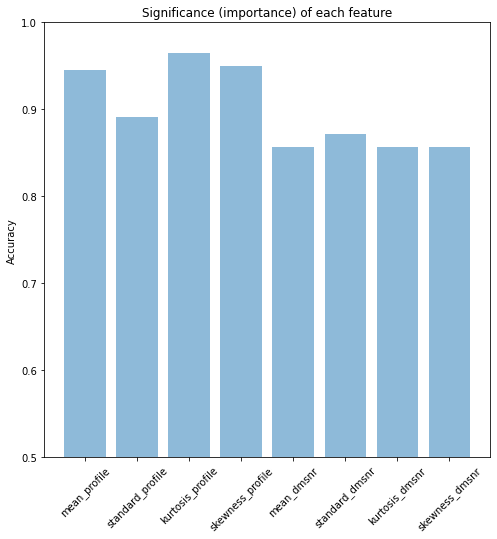

In [39]:
y_pos = np.arange(len(importance_feature_columns))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, importance_feature, align='center', alpha=0.5)
plt.xticks(y_pos, importance_feature_columns, fontsize=10, rotation=45)
plt.ylim(0.5, 1)
plt.ylabel('Accuracy')
plt.title('Significance (importance) of each feature')

plt.show()

In [40]:
## Ranking the features by their importance
dictionary_significance = {}
for index, name in enumerate(importance_feature_columns):
    dictionary_significance[name] = importance_feature[index]

dictionary_significance = sorted(dictionary_significance.items(), key=operator.itemgetter(1))
print(dictionary_significance)

[('mean_dmsnr', 0.8569566027193146), ('kurtosis_dmsnr', 0.8569566027193146), ('skewness_dmsnr', 0.8569566027193146), ('standard_dmsnr', 0.8716707021791767), ('standard_profile', 0.8906686533805178), ('mean_profile', 0.9457999627491153), ('skewness_profile', 0.949711305643509), ('kurtosis_profile', 0.9649841683739989)]


##### Performance drop after removing less important features

In [41]:
performance_feature_columns = []
performance_feature = []

for index in range(dataset.shape[1] - 1):
    ## Get the column
    x = dataset.drop([dataset.columns[index], 'target'], axis='columns').values
    y = dataset['target'].values

    ## Index for 30%
    i_30 = int(0.3 * len(dataset_np[:, 0]))

    ## Split into training and validation
    xvalid = x[:i_30]
    yvalid = y[:i_30]
    
    xtrain = x[i_30:]
    ytrain = y[i_30:]

    ## Mean normalization
    min = xtrain.min(axis = 0) 
    max = xtrain.max(axis = 0) 
    mean = xtrain.mean(axis = 0)
    xtrain = (xtrain - mean) / (max - min)
    xvalid = (xvalid - mean) / (max - min)

    ## Rescaling
    ymax = ytrain.max()
    ytrain = ytrain / ymax
    yvalid = yvalid / ymax

    ## Callback
    callback_a = ModelCheckpoint(filepath = "feature_removal.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=100, verbose=0)

    ## Model
    model = Sequential()
    model.add(Dense(8, input_dim=len(xtrain[0, :]), activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    ## Compile Model
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    history = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=1024, batch_size=100, callbacks=[callback_a, callback_b], verbose=0)
    
    ## Prediction
    prediction = model.predict(xvalid, verbose=0)
    prediction = (prediction > 0.5)
    acc_score = accuracy_score(yvalid, prediction)

    ## Store Accuracy
    performance_feature_columns.append(dataset.columns[index])
    performance_feature.append(acc_score)
    print("%s | %s | %s" % (datetime.datetime.now(pytz.timezone('US/Central')).strftime("%Y/%m/%d %I:%M:%S %p"), dataset.columns[index], acc_score))
## ~~~
print()
print(performance_feature_columns)
print(performance_feature)

2020/05/06 06:17:38 PM | mean_profile | 0.9713168187744459
2020/05/06 06:19:20 PM | standard_profile | 0.9711305643509033
2020/05/06 06:22:39 PM | kurtosis_profile | 0.9679642391506799
2020/05/06 06:25:19 PM | skewness_profile | 0.9728068541627863
2020/05/06 06:27:54 PM | mean_dmsnr | 0.9729931085863289
2020/05/06 06:30:01 PM | standard_dmsnr | 0.9713168187744459
2020/05/06 06:32:15 PM | kurtosis_dmsnr | 0.9722480908921587
2020/05/06 06:35:16 PM | skewness_dmsnr | 0.9687092568448501

['mean_profile', 'standard_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr', 'standard_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr']
[0.9713168187744459, 0.9711305643509033, 0.9679642391506799, 0.9728068541627863, 0.9729931085863289, 0.9713168187744459, 0.9722480908921587, 0.9687092568448501]


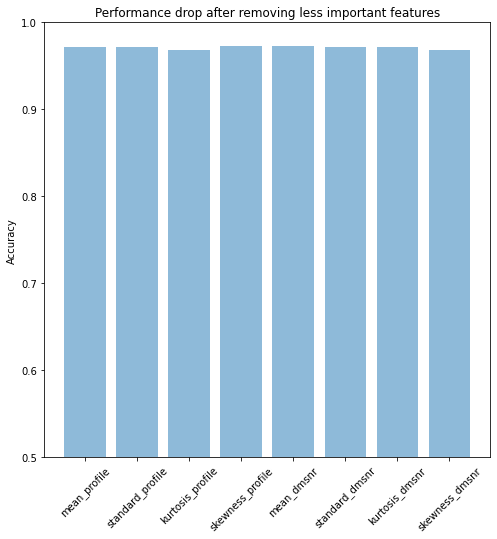

In [42]:
y_pos = np.arange(len(performance_feature_columns))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, performance_feature, align='center', alpha=0.5)
plt.xticks(y_pos, performance_feature_columns, fontsize=10, rotation=45)
plt.ylim(0.5, 1)
plt.ylabel('Accuracy')
plt.title('Performance drop after removing less important features')

plt.show()

In [43]:
## Ranking the features by their performance
dictionary_performance = {}
for index, name in enumerate(performance_feature_columns):
    dictionary_performance[name] = performance_feature[index]

dictionary_performance = sorted(dictionary_performance.items(), key=operator.itemgetter(1))
print(dictionary_performance)

[('kurtosis_profile', 0.9679642391506799), ('skewness_dmsnr', 0.9687092568448501), ('standard_profile', 0.9711305643509033), ('mean_profile', 0.9713168187744459), ('standard_dmsnr', 0.9713168187744459), ('kurtosis_dmsnr', 0.9722480908921587), ('skewness_profile', 0.9728068541627863), ('mean_dmsnr', 0.9729931085863289)]


##### Removing two features

In [44]:
two_feature_columns = []
two_feature = []

combo = combinations(list(range(dataset.shape[1] - 1)), 2)
for c in list(combo):
    ## Get the column
    x = dataset.drop([dataset.columns[c[0]], dataset.columns[c[1]], 'target'], axis='columns').values
    y = dataset['target'].values

    ## Index for 30%
    i_30 = int(0.3 * len(dataset_np[:, 0]))

    ## Split into training and validation
    xvalid = x[:i_30]
    yvalid = y[:i_30]
    
    xtrain = x[i_30:]
    ytrain = y[i_30:]

    ## Mean normalization
    min = xtrain.min(axis = 0) 
    max = xtrain.max(axis = 0) 
    mean = xtrain.mean(axis = 0)
    xtrain = (xtrain - mean) / (max - min)
    xvalid = (xvalid - mean) / (max - min)

    ## Rescaling
    ymax = ytrain.max()
    ytrain = ytrain / ymax
    yvalid = yvalid / ymax

    ## Callback
    callback_a = ModelCheckpoint(filepath = "feature_removal.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=100, verbose=0)

    ## Model
    model = Sequential()
    model.add(Dense(8, input_dim=len(xtrain[0, :]), activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    ## Compile Model
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    history = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=1024, batch_size=100, callbacks=[callback_a, callback_b], verbose=0)
    
    ## Prediction
    prediction = model.predict(xvalid, verbose=0)
    prediction = (prediction > 0.5)
    acc_score = accuracy_score(yvalid, prediction)

    ## Store Accuracy
    pair_name = "%s:%s" % (dataset.columns[c[0]], dataset.columns[c[1]])
    two_feature_columns.append(pair_name)
    two_feature.append(acc_score)
    print("%s | %s | %s" % (datetime.datetime.now(pytz.timezone('US/Central')).strftime("%Y/%m/%d %I:%M:%S %p"), pair_name, acc_score))
## ~~~
print()
print(two_feature_columns)
print(two_feature)

2020/05/06 06:37:16 PM | mean_profile:standard_profile | 0.971689327621531
2020/05/06 06:38:39 PM | mean_profile:kurtosis_profile | 0.9679642391506799
2020/05/06 06:41:11 PM | mean_profile:skewness_profile | 0.9709443099273608
2020/05/06 06:43:14 PM | mean_profile:mean_dmsnr | 0.9698267833861054
2020/05/06 06:45:25 PM | mean_profile:standard_dmsnr | 0.9694542745390203
2020/05/06 06:46:52 PM | mean_profile:kurtosis_dmsnr | 0.9707580555038182
2020/05/06 06:48:34 PM | mean_profile:skewness_dmsnr | 0.970385546656733
2020/05/06 06:51:11 PM | standard_profile:kurtosis_profile | 0.9612590799031477
2020/05/06 06:53:18 PM | standard_profile:skewness_profile | 0.9729931085863289
2020/05/06 06:55:55 PM | standard_profile:mean_dmsnr | 0.9724343453157013
2020/05/06 07:00:12 PM | standard_profile:standard_dmsnr | 0.9718755820450735
2020/05/06 07:02:17 PM | standard_profile:kurtosis_dmsnr | 0.9726205997392438
2020/05/06 07:04:34 PM | standard_profile:skewness_dmsnr | 0.971689327621531
2020/05/06 07:0

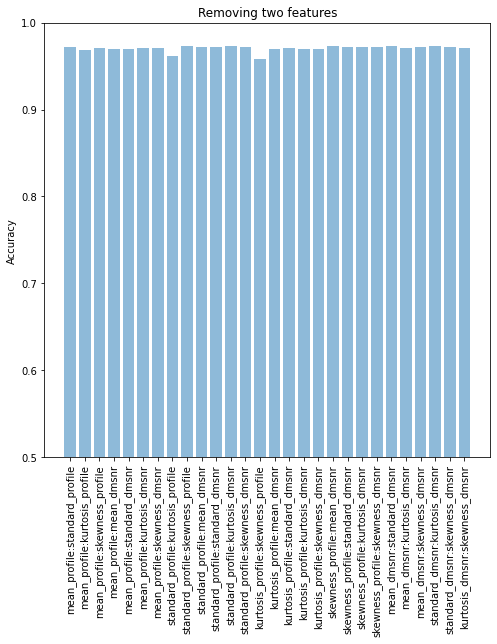

In [45]:
y_pos = np.arange(len(two_feature_columns))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, two_feature, align='center', alpha=0.5)
plt.xticks(y_pos, two_feature_columns, fontsize=10, rotation=90)
plt.ylim(0.5, 1)
plt.ylabel('Accuracy')
plt.title('Removing two features')

plt.show()

Side by Side

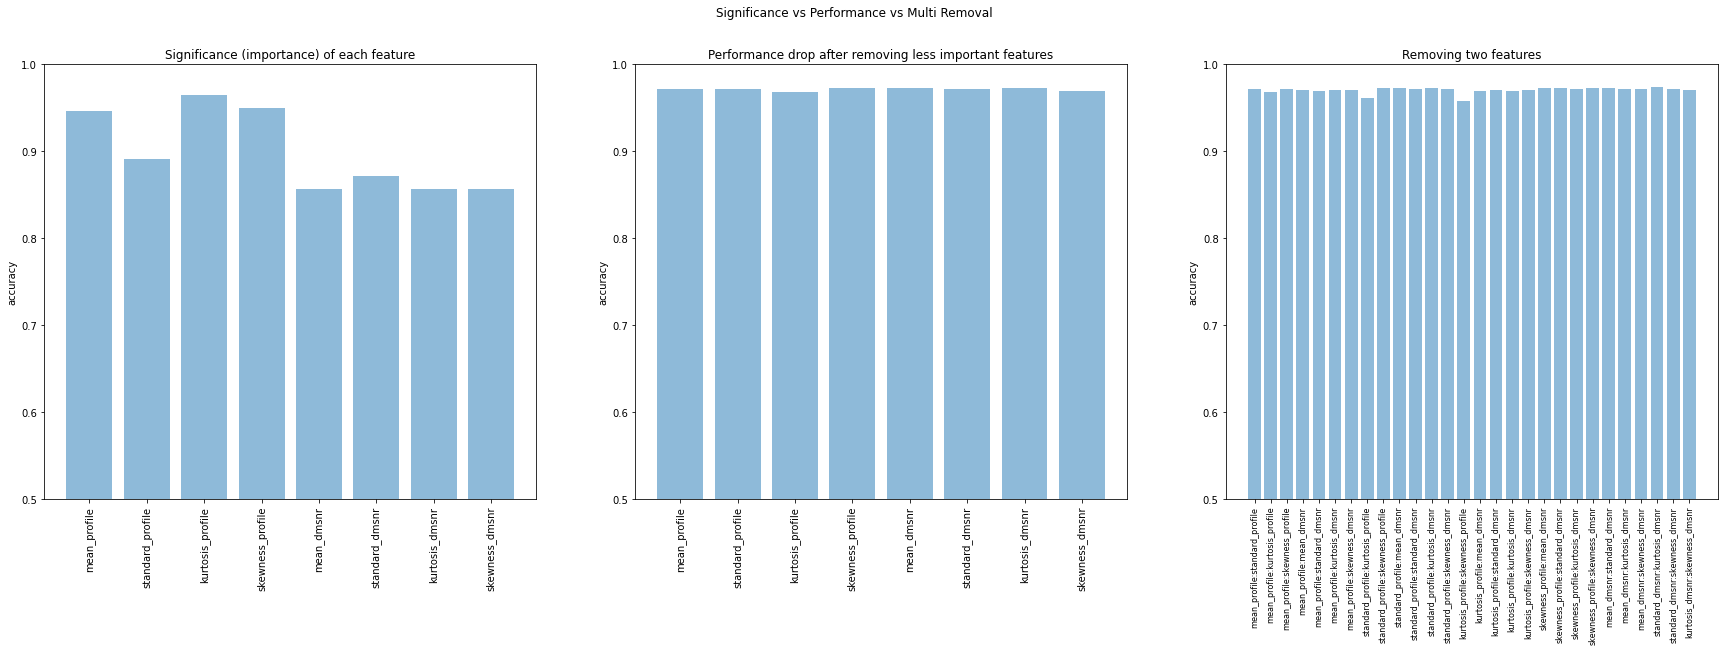

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle("Significance vs Performance vs Multi Removal")

ax1.bar(np.arange(len(importance_feature_columns)), importance_feature, align='center', alpha=0.5)
ax1.set_xticks(np.arange(len(importance_feature_columns)))
ax1.set_xticklabels(importance_feature_columns, fontsize=10, rotation=90)
ax1.set_ylim(0.5, 1)
ax1.set_ylabel('accuracy')
ax1.set_title('Significance (importance) of each feature')

ax2.bar(np.arange(len(performance_feature_columns)), performance_feature, align='center', alpha=0.5)
ax2.set_xticks(np.arange(len(performance_feature_columns)))
ax2.set_xticklabels(performance_feature_columns, fontsize=10, rotation=90)
ax2.set_ylim(0.5, 1)
ax2.set_ylabel('accuracy')
ax2.set_title('Performance drop after removing less important features')

ax3.bar(np.arange(len(two_feature_columns)), two_feature, align='center', alpha=0.5)
ax3.set_xticks(np.arange(len(two_feature_columns)))
ax3.set_xticklabels(two_feature_columns, fontsize=8, rotation=90)
ax3.set_ylim(0.5, 1)
ax3.set_ylabel('accuracy')
ax3.set_title('Removing two features')

fig.show()

## **XGBoost**

In [0]:
xg_cla = xgb.XGBClassifier(n_estimators=1700, max_depth=3)

In [48]:
xg_cla.fit(XTRAIN, YTRAIN, eval_set=[(XVALID, YVALID)], verbose=1)

[0]	validation_0-error:0.020391
[1]	validation_0-error:0.02095
[2]	validation_0-error:0.02067
[3]	validation_0-error:0.020391
[4]	validation_0-error:0.020112
[5]	validation_0-error:0.020112
[6]	validation_0-error:0.020112
[7]	validation_0-error:0.019832
[8]	validation_0-error:0.019832
[9]	validation_0-error:0.020112
[10]	validation_0-error:0.020391
[11]	validation_0-error:0.020112
[12]	validation_0-error:0.020112
[13]	validation_0-error:0.020112
[14]	validation_0-error:0.020112
[15]	validation_0-error:0.020112
[16]	validation_0-error:0.019832
[17]	validation_0-error:0.020112
[18]	validation_0-error:0.020112
[19]	validation_0-error:0.020112
[20]	validation_0-error:0.020112
[21]	validation_0-error:0.020112
[22]	validation_0-error:0.020112
[23]	validation_0-error:0.020112
[24]	validation_0-error:0.020112
[25]	validation_0-error:0.020112
[26]	validation_0-error:0.020112
[27]	validation_0-error:0.020112
[28]	validation_0-error:0.020112
[29]	validation_0-error:0.020112
[30]	validation_0-erro

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1700, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
def xgb_evaluation_classification(model, xtrain, ytrain, xvalid, yvalid):
    preds_train = model.predict(xtrain)
    print(ytrain[:10])
    print(preds_train[:10])
    print()

    preds_valid = model.predict(xvalid)
    print(yvalid[:10])
    print(preds_valid[:10])
    print()

    prediction = model.predict(xvalid)
    accuracy = accuracy_score(yvalid, prediction.round()) * 100.0
    precision = precision_score(yvalid, prediction.round(), average='micro') * 100.0
    recall = recall_score(yvalid, prediction.round(), average='micro') * 100.0
    f1score = f1_score(yvalid, prediction.round(), average='micro')

    print("Accuracy: %.2f%%" % (accuracy))
    print("Precision: %.2f%%" % (precision))
    print("Recall: %.2f%%" % (recall))
    print("F1-score: %.2f\n" % (f1score))
    return prediction

In [50]:
predXGB = xgb_evaluation_classification(xg_cla, XTRAIN, YTRAIN, XVALID, YVALID)

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]

[0 1 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]

Accuracy: 97.96%
Precision: 97.96%
Recall: 97.96%
F1-score: 0.98



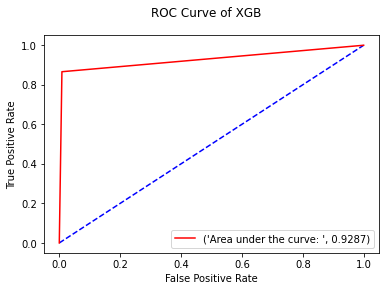

In [51]:
model_performances(YVALID, predXGB, 'ROC Curve of XGB')